<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/Copy_of_New_Way_for_NN_BlackScholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Black-Scholes to Generate Data
# Construct Neural Net

In [ ]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  15339      0 --:--:-- --:--:-- --:--:-- 15339
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [1]:
%%writefile cupy_dataset.py
import cupy
import numpy as np
from torch.utils.dlpack import from_dlpack
from scipy.stats import norm
from math import log, sqrt, pi, exp

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):

          ################################################################################################### generate random input numbers
          # intervals
          iv_s0 = (1.25-0.75)/80
          iv_sigma = (0.45-0.15)/40
          iv_r = (0.6-0.25)/40
          iv_K = (1.25-0.75)/80

          # initial_stocks = np.array(np.random.randint(75,125,self.N_STOCKS)/100)
          # iv_s0 = 0.005
          rnd_s0 = np.arange(0.75, 1.25 + iv_s0, iv_s0)
          initial_stocks = np.array([rnd_s0[i] for i in np.random.randint(0, len(rnd_s0), self.N_STOCKS)])

          corr = np.diag(np.array([1]*self.N_STOCKS)) # assume no correlation between stocks here

          # sigma = np.array(np.random.randint(15,45,self.N_STOCKS)/100)

          # iv_sigma = 0.005
          rnd_sigma = np.arange(0.15, 0.45 + iv_sigma, iv_sigma)
          sigma = np.array([rnd_sigma[i] for i in np.random.randint(0, len(rnd_sigma), self.N_STOCKS)])

          cov = (np.diag(sigma)).dot(corr).dot(np.diag(sigma))

          # r = np.repeat(np.array(np.random.randint(25,60)/100), self.N_STOCKS)
          # iv_r = 0.005
          rnd_r = np.arange(0.25, 0.6 + iv_r, iv_r)
          r = np.repeat(rnd_r[np.random.randint(0,len(rnd_r), 1)], self.N_STOCKS)

          drift = r

          T = self.T
          # K = np.random.randint(75,125)/100
          # iv_K = 0.005
          rnd_K = np.arange(0.75, 1.25 + iv_K, iv_K)
          K = rnd_K[np.random.randint(0, len(rnd_K), 1)]

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas

          European_Call_price = bs_call(initial_stocks,K,T,r,sigma)
          Deltas = bs_delta(initial_stocks,K,T,r,sigma)

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price[0]
          Y[op, 1:4] = cupy.array(Deltas, dtype=cupy.float32)

          # T, K, S, sigma, mu, r
          paras = (np.repeat(np.array(T), self.N_STOCKS), np.repeat(np.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))



# ds = OptionDataSet(max_len = 2, number_path = 1000000, batch = 2, seed = np.random.randint(10000), stocks=1) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

Writing cupy_dataset.py


In [2]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, 32) # remember to change this!
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.3, 0.35, 0.35]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.75, 0.15, 0.25, 0.25]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [3]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 9.8 MB/s 


In [4]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 100000, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  if __name__ == '__main__':


loss 0.3893764913082123 average time 0.07712499650002655 iter num 20
loss 0.36389705538749695 average time 0.054137091075011766 iter num 40
loss 0.3042798638343811 average time 0.04680394411667521 iter num 60
loss 0.34460604190826416 average time 0.04295286473750366 iter num 80
loss 0.2795102000236511 average time 0.040791658370008005 iter num 100
loss 0.28387340903282166 average time 0.0327023625000038 iter num 20
loss 0.25583401322364807 average time 0.03210939797500032 iter num 40
loss 0.2284049093723297 average time 0.03181570838332088 iter num 60
loss 0.2218768447637558 average time 0.03154334498748597 iter num 80
loss 0.2166953831911087 average time 0.031610717079986445 iter num 100
loss 0.18853919208049774 average time 0.03323158695001212 iter num 20
loss 0.15265637636184692 average time 0.03246786822501235 iter num 40
loss 0.1213235855102539 average time 0.032245764900009515 iter num 60
loss 0.09973210841417313 average time 0.03232590555000172 iter num 80
loss 0.101112954318523

Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

9 min

# Save Model

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import torch
model_save_name = 'jax_european_1stock_grid_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

# Load Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
model_save_name = 'jax_european_1stock_grid_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

In [ ]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

In [40]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 500000, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 200)

model_save_name = 'jax_european_1stock_grid_2.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 2.2037447706679814e-05 average time 0.03285779039961199 iter num 20
loss 1.0010827281803358e-05 average time 0.03228145447474162 iter num 40
loss 3.697285592352273e-06 average time 0.03216572104987184 iter num 60
loss 4.466521659196587e-06 average time 0.03192798128739014 iter num 80
loss 2.1637948520947248e-05 average time 0.03168255676988338 iter num 100
loss 8.99094175110804e-06 average time 0.03262864320022345 iter num 20
loss 4.488891136134043e-06 average time 0.03177473587520581 iter num 40
loss 1.653195795370266e-05 average time 0.03193636596679426 iter num 60
loss 4.3711338548746426e-06 average time 0.03177032508765478 iter num 80
loss 4.190393610770116e-06 average time 0.03169099040020228 iter num 100
loss 5.389084890339291e-06 average time 0.03296557780013245 iter num 20
loss 1.008342132990947e-05 average time 0.0321114579002824 iter num 40
loss 6.749827662133612e-06 average time 0.03216327000027377 iter num 60
loss 7.1030012804840226e-06 average time 0.03192433475019243

# Results

In [41]:
import torch
inputs = torch.tensor([[1, 1, 1, 0.25, 0.3, 0.3]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (0.27130044, 0.90763223)

price: tensor([[0.2709]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor([0.9087], device='cuda:0')

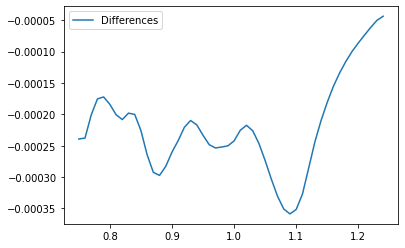

In [42]:
from scipy.stats import norm
from math import log, sqrt, pi, exp
import matplotlib.pyplot as plt

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def compute_price(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.3, 0.3]]).cuda()
    return model(inputs.float())

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
BS_call_prices = []
for p in prices:
    model_call_prices.append(compute_price(p).item())
    BS_call_prices.append(bs_call(p, 1, 1, 0.3, 0.25))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, BS_call_prices, label = "BS_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(BS_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

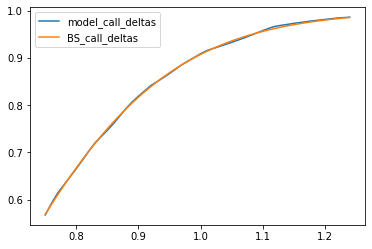

In [43]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.3, 0.3]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1, 1, 0.3, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()


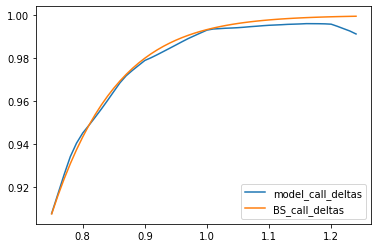

In [44]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 0.75, S, 0.25, 0.3, 0.3]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 0.75, 1, 0.3, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()


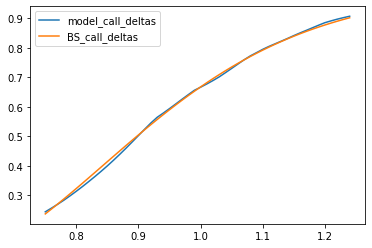

In [45]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1.25, S, 0.25, 0.3, 0.3]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1.25, 1, 0.3, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()
